# Bibliotecas

In [1]:
import math
import os
import re
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from datetime import timedelta
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support , roc_auc_score, auc, precision_score, f1_score
from timeit import default_timer as timer

%run ./base_functions.ipynb

pd.options.mode.chained_assignment = None # desabilita warnings de SettingWithCopyWarning
plt.rcParams.update({'figure.max_open_warning': 0}) # desabilita warning para plot de mais de 20 figuras

In [2]:
# Caminho no qual as imagens geradas serão salvas quando exportadas
saving_path = r"C:\Users\anaso\Desktop\workspace\doutorado\imagens"

# Funções

In [3]:
class PCA():
   
    # ---------------------------------------------------------------------------
    # Método construtor
    # Função que será chamada toda vez que um objeto PCA for inicializado
    # O modelo selecionará quantos PCs forem necessários para cumprir o % de variabilidade explicada especificado em a

    def __init__ (self, a=0.9):

        # se 0<=a<1,  'a' indica a fraçao de variancia explicada desejada
        # se a>=1,    'a' indica o numero de componentes desejado
        self.a = a
   
    # ---------------------------------------------------------------------------
    # Função para treino do modelo
    # X são os dados de treino
    
    def fit(self, X, conf_Q=0.99, conf_T2=0.99, plot=True):
    
        # guardando médias e desvios-padrão do treino (de cada coluna)
        self.mu_train = X.mean(axis=0)
        self.std_train = X.std(axis=0)        
       
        # normalizando dados de treino
        X = np.array(((X - self.mu_train)/self.std_train))
       
        # calculando a matriz de covariâncias dos dados
        Cx = np.cov(X, rowvar=False)
        
        # aplicando decomposição em autovalores e autovetores
        self.L, self.P = np.linalg.eig(Cx)
        
        # frações da variância explicada
        fv = self.L/np.sum(self.L)
        
        # frações da variância explicada acumuladas
        fva = np.cumsum(self.L)/sum(self.L)
       
        # definindo número de componentes
        if (self.a>0 and self.a<1):
            self.a = np.where(fva>self.a)[0][0]+1 
            
        # calculando limites de detecção

        # limite da estatística T^2
        from scipy.stats import f
        F = f.ppf(conf_T2, self.a, X.shape[0]-self.a)
        self.T2_lim = ((self.a*(X.shape[0]**2-1))/(X.shape[0]*(X.shape[0]-self.a)))*F
        print("T2_lim: ", self.T2_lim)
        
        # limite da estatística Q
        theta = [np.sum(self.L[self.a:]**(i)) for i in (1,2,3)]
        ho = 1-((2*theta[0]*theta[2])/(3*(theta[1]**2)))
        from scipy.stats import norm
        nalpha = norm.ppf(conf_Q)
        self.Q_lim = (theta[0]*(((nalpha*np.sqrt(2*theta[1]*ho**2))/theta[0])+1+
                                ((theta[1]*ho*(ho-1))/theta[0]**2))**(1/ho))
        print("Q_lim: ", self.Q_lim)
        
        # plotando variâncias explicadas
        if plot:
            fig, ax = plt.subplots()
            ax.bar(np.arange(len(fv)),fv)
            ax.plot(np.arange(len(fv)),fva)
            ax.set_xlabel('Número de componentes')
            ax.set_ylabel('Variância dos dados')
            ax.set_title('PCA - Variância Explicada');

    # ---------------------------------------------------------------------------
    # Função para teste do modelo
            
    def predict(self, X):
            
        # normalizando dados de teste (usando os parâmetros do treino!)
        X = np.array((X - self.mu_train)/self.std_train)

        # calculando estatística T^2
        T = X@self.P[:,:self.a]
        self.T2 = np.array([T[i,:]@np.linalg.inv(np.diag(self.L[:self.a]))@T[i,:].T for i in range(X.shape[0])])
        
        # calculando estatística Q
        e = X - X@self.P[:,:self.a]@self.P[:,:self.a].T
        self.Q  = np.array([e[i,:]@e[i,:].T for i in range(X.shape[0])])
        
        # calculando contribuições para Q
        self.c = np.absolute(X*e) 
                
    # ---------------------------------------------------------------------------
    # Função para plotar cartas de controle
    
    def plot_control_charts(self, fault = None):
     
        fig, ax = plt.subplots(1,2, figsize=(15,3))
        
        ax[0].semilogy(self.T2,'.')
        ax[0].axhline(self.T2_lim,ls='--',c='r');
        ax[0].set_title('Carta de Controle $T^2$')
        
        ax[1].semilogy(self.Q,'.')
        ax[1].axhline(self.Q_lim,ls='--',c='r')
        ax[1].set_title('Carta de Controle Q')
 
        if fault is not None:
            ax[0].axvline(fault, c='w')
            ax[1].axvline(fault, c='w')

    # ---------------------------------------------------------------------------
    # Função para plotar mapas de contribuição
            
    def plot_contributions(self, fault=None, index=None, columns=None):

        fig, ax = plt.subplots(figsize=(20, 6))
        
        c = pd.DataFrame(self.c, index=index, columns=columns)
    
        sns.heatmap(c, ax=ax, yticklabels=int(self.c.shape[0]/10), cmap = plt.cm.Blues)
        
        ax.set_title('Contribuições parciais para Q')
        
        if fault is not None:
            ax.axhline(y=c.index[fault], ls='--', c='k')

In [4]:
def print_overview(data):
    
    """
    Retorna algumas informações gerais sobre o banco de dados, como existência de nulos e duplicatas, dentre outros.
    """
    
    # Shape do banco
    print("Shape do banco: ", data.shape)
    
    # Alguma linha com todos os valores zerados?
    zero_rows = data.index[(data==0).all(axis=1)].tolist()
    print("\nQuantidade de linhas zeradas: ", len(zero_rows))
    
    # Existem nulos?
    print("Quantidade de nulos no banco: ", data.isnull().sum().sum())
    
    # Há duplicatas baseado no timestamp?
    qtd_duplis = len(data[data.duplicated(['timestamp'])])
    if (qtd_duplis > 0):
        print("Quantidade de duplicatas: ", qtd_duplis)
#         print(data[data.duplicated(['timestamp'])])
    else:
        print("\nNão há registros duplicados.")
    
    print()
    
    # Alguma coluna possui um único valor constante?
    single_values_columns = []
    for col in (data.columns):
        unique_values = data[col].nunique()
        if (unique_values == 1):
            single_values_columns.append(col)
    if len(single_values_columns) > 0:
        print("Existem " + str(len(single_values_columns)) + " colunas constantes. São elas: " + str(single_values_columns))
    else:
        print("Não há colunas constantes.")
    
    # Alguma linha inteiramente zerada?
    data_sem_dt = data.drop(['timestamp'], 1)
    zero_rows = data_sem_dt.index[(data_sem_dt == 0).all(axis=1)].tolist()
    if len(zero_rows) > 0:
        print("Existem " + str(len(zero_rows)) + " linhas inteiramente zeradas.")
    else:
        print("Não há linhas inteiramente zeradas.")
    
    # Alguma linha com todas as colunas NaN?
    nan_rows = data.index[(data == float('nan')).all(axis=1)].tolist()
    if len(nan_rows) > 0:
        print("Existem " + str(len(nan_rows)) + " instâncias sem registro.")
    else:
        print("Não há linhas inteiramente sem registro (nan).")

# Leitura dos arquivos

In [5]:
data = pd.read_csv("D:\\TEP - Python\\09-python_dados-3anos.csv", sep=';')
data_total = data.drop(['Unnamed: 0'], 1)

data2 = pd.read_csv("D:\\TEP - Python\\13-python_dados-1ano.csv", sep=';')
data_teste = data2.drop(['Unnamed: 0'], 1)

In [6]:
print("Treino: ", np.shape(data_total))
print("Teste:  ", np.shape(data_teste))

Treino:  (525600, 53)
Teste:   (175200, 53)


In [7]:
# sim_status = pd.read_csv("D:\\TEP - Python\\09-params-3anos.csv", sep=';')
# sim_status = sim_status.drop(['Unnamed: 0'], 1)

# sim_status2 = pd.read_csv("D:\\TEP - Python\\13-params-1ano.csv", sep=';')
# sim_status_teste = sim_status2.drop(['Unnamed: 0'], 1)

# Divisão dos bancos de dados

In [8]:
x_treino = data_total.copy()
x_treino = x_treino[x_treino['STATUS'] == 0].copy()
y_treino = x_treino[['STATUS']].copy()
x_treino.drop(['STATUS'], axis=1, inplace=True)

x_teste = data_teste.copy()
y_teste = x_teste[['STATUS']].copy()
x_teste.drop(['STATUS'], axis=1, inplace=True)

print("TREINO:")
print(x_treino.shape)
print(y_treino.shape)
print()

print("\nTESTE:")
print(x_teste.shape)
print(y_teste.shape)

TREINO:
(264912, 52)
(264912, 1)


TESTE:
(175200, 52)
(175200, 1)


# PCA 

#### Treinamento

T2_lim:  41.64363577805298
Q_lim:  10.376272449274065

PCs:  23


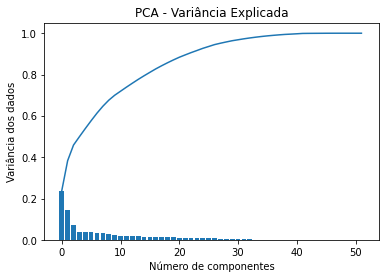

In [9]:
# Instancia o objeto PCA
pca = PCA(a=0.9)

# Treina o modelo PCA
pca.fit(x_treino)

print("\nPCs: ", pca.a)

#### Teste

In [10]:
pca.predict(x_teste)


T2: 0.2020662100456621
Q:  0.22237442922374429


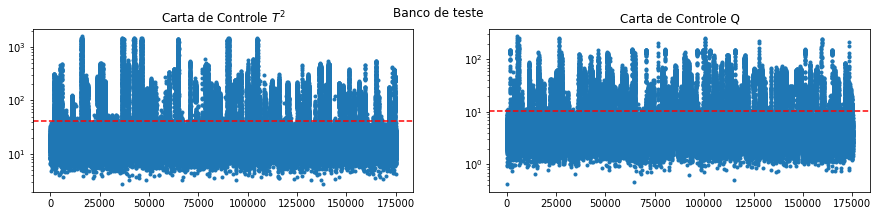

In [11]:
print(f'\nT2: {(pca.T2>pca.T2_lim).sum()/pca.T2.shape[0]}')
print(f'Q:  {(pca.Q>pca.Q_lim).sum()/pca.Q.shape[0]}')

pca.plot_control_charts()
plt.suptitle(f'Banco de teste');

In [12]:
pca_results = pd.DataFrame(columns=['T2', 'Q'])
pca_results['T2'] = pca.T2
pca_results['Q'] = pca.Q 
pca_results['rotulos_multi'] = y_teste.values
pca_results['rotulos_bin'] = np.where(pca_results['rotulos_multi'] >= 1, 1, 0)

In [13]:
pca_results['T2_classific'] = np.where(pca_results['T2'] > pca.T2_lim, 1, 0)
pca_results['Q_classific'] = np.where(pca_results['Q'] > pca.Q_lim, 1, 0)

pca_results['T2_classific_multi'] = np.where(pca_results['T2'] > pca.T2_lim, pca_results['rotulos_multi'], 0)
pca_results['Q_classific_multi'] = np.where(pca_results['Q'] > pca.Q_lim, pca_results['rotulos_multi'], 0)

pca_results = pca_results.reset_index().drop(['index'], axis=1)
pca_results

,T2,Q,rotulos_multi,rotulos_bin,T2_classific,Q_classific,T2_classific_multi,Q_classific_multi
0,9.433204,0.415648,0,0,0,0,0,0
1,10.924147,1.345793,0,0,0,0,0,0
2,11.133426,1.843677,0,0,0,0,0,0
3,19.363389,3.698751,0,0,0,0,0,0
4,6.837100,6.630584,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
175195,8.672413,3.835468,15,1,0,0,0,0
175196,19.549150,4.445620,15,1,0,0,0,0
175197,14.880747,6.236796,15,1,0,0,0,0
175198,13.094587,4.517914,15,1,0,0,0,0


#### Binário

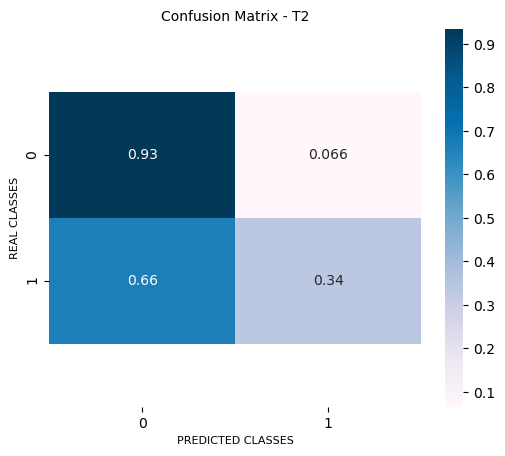


Overall Precision:       83.69%
Overall Recall:          33.62%
Overall F-score(a=1):    47.97%
Overall F-score(a=0.5):  55.92%
Overall F-score(a=2):    41.99%
Overall Specificity:     93.37%
Overall FPR(FAR):        6.63%
Overall Accuracy:        63.31%


In [14]:
# Desempenho por T2

new_status = [0,1]

df_cm = pd.DataFrame(confusion_matrix(pca_results['rotulos_bin'], pca_results['T2_classific']), \
                     index=[i for i in new_status], columns=[i for i in new_status])

# Linha para normalizar os dados
df_cm_norm = round((df_cm.astype('float')/df_cm.sum(axis=1).values.reshape(-1,1)), 3)

# Gráfico da matriz de confusão
plt.figure(figsize=(6,5), dpi=100)
plt.title("Confusion Matrix - T2", fontsize=10)
ax = sn.heatmap(df_cm_norm, annot=True, cmap='PuBu')
ax.set_xlabel("PREDICTED CLASSES", fontsize=8)
ax.set_ylabel("REAL CLASSES", fontsize=8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

tn, fp, fn, tp = confusion_matrix(pca_results['rotulos_bin'], pca_results['T2_classific']).ravel()
        
recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1_score = 2*recall*precision/(recall+precision)
f2_score = 3*recall*precision/((2*precision)+recall)
f05_score = 1.5*recall*precision/((0.5*precision)+recall)
accuracy = (tp+tn)/(tp+tn+fp+fn)
specificity = tn/(fp+tn)
fpr = fp/(fp+tn)

metricas_df = pd.DataFrame([precision, recall, f1_score, f05_score, f2_score, specificity, accuracy, fpr, tp, \
                            tn, fp, fn]).T
metricas_df.columns = ['Precision', 'Recall', 'F-score(a=1)', 'F-score(a=0.5)', 'F-score(a=2)', \
                       'Specificity', 'Accuracy', 'FPR(FAR)', 'TP', 'TN', 'FP', 'FN']

print("\nOverall Precision:       {:.2f}%".format((metricas_df['Precision'].values.item()*100)))
print("Overall Recall:          {:.2f}%".format((metricas_df['Recall'].values.item()*100)))
print("Overall F-score(a=1):    {:.2f}%".format((metricas_df['F-score(a=1)'].values.item()*100)))
print("Overall F-score(a=0.5):  {:.2f}%".format((metricas_df['F-score(a=0.5)'].values.item()*100)))
print("Overall F-score(a=2):    {:.2f}%".format((metricas_df['F-score(a=2)'].values.item()*100)))
print("Overall Specificity:     {:.2f}%".format((metricas_df['Specificity'].values.item()*100)))
print("Overall FPR(FAR):        {:.2f}%".format((metricas_df['FPR(FAR)'].values.item()*100)))
print("Overall Accuracy:        {:.2f}%".format((metricas_df['Accuracy'].values.item()*100)))

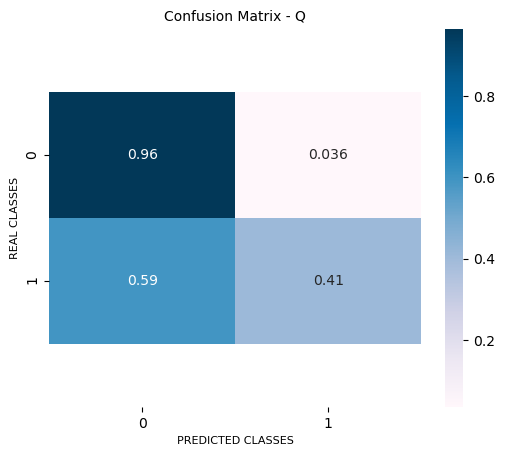


Overall Precision:       92.06%
Overall Recall:          40.69%
Overall F-score(a=1):    56.44%
Overall F-score(a=0.5):  64.80%
Overall F-score(a=2):    49.99%
Overall Specificity:     96.45%
Overall FPR(FAR):        3.55%
Overall Accuracy:        68.40%


In [15]:
# Desempenho por Q

new_status = [0,1]

df_cm = pd.DataFrame(confusion_matrix(pca_results['rotulos_bin'], pca_results['Q_classific']), \
                     index=[i for i in new_status], columns=[i for i in new_status])

# Linha para normalizar os dados
df_cm_norm = round((df_cm.astype('float')/df_cm.sum(axis=1).values.reshape(-1,1)), 3)

# Gráfico da matriz de confusão
plt.figure(figsize=(6,5), dpi=100)
plt.title("Confusion Matrix - Q", fontsize=10)
ax = sn.heatmap(df_cm_norm, annot=True, cmap='PuBu')
ax.set_xlabel("PREDICTED CLASSES", fontsize=8)
ax.set_ylabel("REAL CLASSES", fontsize=8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

tn, fp, fn, tp = confusion_matrix(pca_results['rotulos_bin'], pca_results['Q_classific']).ravel()
        
recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1_score = 2*recall*precision/(recall+precision)
f2_score = 3*recall*precision/((2*precision)+recall)
f05_score = 1.5*recall*precision/((0.5*precision)+recall)
accuracy = (tp+tn)/(tp+tn+fp+fn)
specificity = tn/(fp+tn)
fpr = fp/(fp+tn)

metricas_df = pd.DataFrame([precision, recall, f1_score, f05_score, f2_score, specificity, accuracy, fpr, tp, \
                            tn, fp, fn]).T
metricas_df.columns = ['Precision', 'Recall', 'F-score(a=1)', 'F-score(a=0.5)', 'F-score(a=2)', \
                       'Specificity', 'Accuracy', 'FPR(FAR)', 'TP', 'TN', 'FP', 'FN']

print("\nOverall Precision:       {:.2f}%".format((metricas_df['Precision'].values.item()*100)))
print("Overall Recall:          {:.2f}%".format((metricas_df['Recall'].values.item()*100)))
print("Overall F-score(a=1):    {:.2f}%".format((metricas_df['F-score(a=1)'].values.item()*100)))
print("Overall F-score(a=0.5):  {:.2f}%".format((metricas_df['F-score(a=0.5)'].values.item()*100)))
print("Overall F-score(a=2):    {:.2f}%".format((metricas_df['F-score(a=2)'].values.item()*100)))
print("Overall Specificity:     {:.2f}%".format((metricas_df['Specificity'].values.item()*100)))
print("Overall FPR(FAR):        {:.2f}%".format((metricas_df['FPR(FAR)'].values.item()*100)))
print("Overall Accuracy:        {:.2f}%".format((metricas_df['Accuracy'].values.item()*100)))

#### Multiclasse

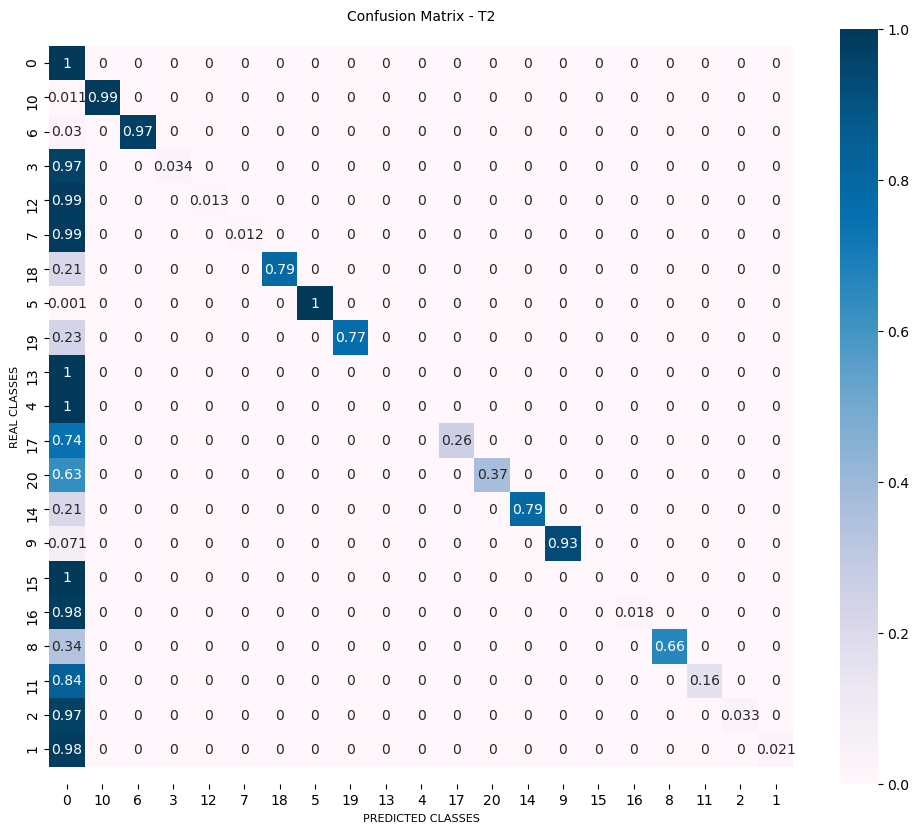

,Precision,Recall,F-score(a=1),F-score(a=0.5),F-score(a=2),Specificity,Accuracy,FPR(FAR),TP,TN,FP,FN,Total
Class,,,,,,,,,,,,,
0,0.598075,1.000000,0.748494,0.690598,0.816987,0.999932,0.999930,0.000068,1,175186,12,0,87063
10,1.000000,0.988801,0.994369,0.996239,0.992506,1.000000,1.000000,0.000000,0,175199,0,0,4911
6,1.000000,0.969992,0.984768,0.989793,0.979793,1.000000,1.000000,0.000000,0,175199,0,0,1333
3,1.000000,0.034041,0.065841,0.095614,0.050207,1.000000,0.999994,0.000000,0,175199,0,0,3437
12,1.000000,0.012848,0.025370,0.037579,0.019149,1.000000,0.999994,0.000000,0,175199,0,0,8328
7,1.000000,0.012101,0.023912,0.035444,0.018042,1.000000,0.999994,0.000000,0,175199,0,0,6446
18,1.000000,0.792453,0.884211,0.919708,0.851351,1.000000,0.999999,0.000000,0,175199,0,0,742
5,1.000000,0.998700,0.999350,0.999566,0.999133,1.000000,1.000000,0.000000,0,175199,0,0,4615
19,1.000000,0.769128,0.869500,0.909043,0.833253,1.000000,0.999999,0.000000,0,175199,0,0,5254


In [16]:
# Desempenho por T2

new_status = y_teste.STATUS.unique()

df_cm = pd.DataFrame(confusion_matrix(pca_results['rotulos_multi'], pca_results['T2_classific_multi']), \
                     index=[i for i in new_status], columns=[i for i in new_status])

# Linha para normalizar os dados
df_cm_norm = round((df_cm.astype('float')/df_cm.sum(axis=1).values.reshape(-1,1)), 3)

# Gráfico da matriz de confusão
plt.figure(figsize=(12,10), dpi=100)
plt.title("Confusion Matrix - T2", fontsize=10)
ax = sn.heatmap(df_cm_norm, annot=True, cmap='PuBu')
ax.set_xlabel("PREDICTED CLASSES", fontsize=8)
ax.set_ylabel("REAL CLASSES", fontsize=8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

cm_values = df_cm_norm.values
    
# Cálculo dos FP, FN e TP para cada classe
tp = np.zeros((len(cm_values),1))
tn = np.zeros((len(cm_values),1))
fp = np.zeros((len(cm_values),1))
fn = np.zeros((len(cm_values),1))
acc = np.zeros((len(cm_values),1))

for i in range(0, len(cm_values)):

    tp[i] = cm_values[i,i]
    fp[i] = cm_values[:,i].sum() - cm_values[i,i]
    fn[i] = cm_values[i,:].sum() - cm_values[i,i]
    tn[i] = len(pca_results['T2_classific_multi']) - tp[i] - fp[i] - fn[i]
    acc[i] = (len(pca_results['T2_classific_multi']) - (cm_values[i,:].sum() + cm_values[:,i].sum() - 2*cm_values[i,i]))/len(pca_results['T2_classific_multi'])

# Cálculo das métricas Precision, Recall e F-Score para cada classe
metricas = precision_recall_fscore_support(pca_results['rotulos_multi'], pca_results['T2_classific_multi'], zero_division=0)

# Arranjo do dataframe e inclusão de outras métricas
metricas_df = pd.DataFrame(list(metricas))
metricas_df = metricas_df.transpose()

metricas_df.columns = ['Precision', 'Recall', 'F-score(a=1)', 'Total']
metricas_df['Accuracy'] = acc
metricas_df['Class'] = new_status
metricas_df['Total'] = metricas_df['Total'].astype(int)

metricas_df['TP'] = tp.astype(int)
metricas_df['TN'] = tn.astype(int)
metricas_df['FP'] = fp.astype(int)
metricas_df['FN'] = fn.astype(int)

metricas_df['Specificity'] = (metricas_df['TN']/(metricas_df['TN'] + metricas_df['FP']))
metricas_df['FPR(FAR)'] = (metricas_df['FP']/(metricas_df['FP'] + metricas_df['TN']))
metricas_df['F-score(a=0.5)'] =\
    (1.5*metricas_df['Precision']*metricas_df['Recall'])/((0.5*metricas_df['Precision']) + metricas_df['Recall'])
metricas_df['F-score(a=2)'] =\
    (3*metricas_df['Precision']*metricas_df['Recall'])/((2*metricas_df['Precision']) + metricas_df['Recall'])
metricas_df['F-score(a=0.5)'].fillna(0, inplace=True)
metricas_df['F-score(a=2)'].fillna(0, inplace=True)

metricas_df = metricas_df.set_index('Class')
metricas_df = metricas_df[['Precision', 'Recall', 'F-score(a=1)', 'F-score(a=0.5)', 'F-score(a=2)', \
                           'Specificity', 'Accuracy', 'FPR(FAR)', 'TP', 'TN', 'FP', 'FN', 'Total']]

metricas_df

In [17]:
pr_micro = precision_score(pca_results['rotulos_multi'], pca_results['T2_classific_multi'], labels=new_status, average='micro')
pr_macro = precision_score(pca_results['rotulos_multi'], pca_results['T2_classific_multi'], labels=new_status, average='macro')
pr_weigh = precision_score(pca_results['rotulos_multi'], pca_results['T2_classific_multi'], labels=new_status, average='weighted')

rc_micro = recall_score(pca_results['rotulos_multi'], pca_results['T2_classific_multi'], labels=new_status, average='micro')
rc_macro = recall_score(pca_results['rotulos_multi'], pca_results['T2_classific_multi'], labels=new_status, average='macro')
rc_weigh = recall_score(pca_results['rotulos_multi'], pca_results['T2_classific_multi'], labels=new_status, average='weighted')

# f1_micro = f1_score(pca_results['rotulos_multi'], pca_results['T2_classific_multi'], labels=new_status, average='micro')
# f1_macro = f1_score(pca_results['rotulos_multi'], pca_results['T2_classific_multi'], labels=new_status, average='macro')
# f1_weigh = f1_score(pca_results['rotulos_multi'], pca_results['T2_classific_multi'], labels=new_status, average='weighted')

print("PRECISION")
print("micro:    {:.2f}%".format((pr_micro*100)))
print("macro:    {:.2f}%".format((pr_macro*100)))
print("weighted: {:.2f}%".format((pr_weigh*100)))

print("\nRECALL")
print("micro:    {:.2f}%".format((rc_micro*100)))
print("macro:    {:.2f}%".format((rc_macro*100)))
print("weighted: {:.2f}%".format((rc_weigh*100)))

# print("\nF-SCORE (a=1)")
# print("micro:    {:.2f}%".format((f1_micro*100)))
# print("macro:    {:.2f}%".format((f1_macro*100)))
# print("weighted: {:.2f}%".format((f1_weigh*100)))
print()

try:
    print("Overall AUC:       {:.2f}%".format((roc_auc_score(pca_results['rotulos_multi'], pca_results['T2_classific_multi'])*100)))
except:
    pass
print("Overall Accuracy:    {:.2f}%".format(accuracy_score(pca_results['rotulos_multi'], pca_results['T2_classific_multi'])*100))

C:\Users\anaso\AppData\Local\Continuum\anaconda3\envs\doc-ana\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PRECISION
micro:    66.60%
macro:    93.32%
weighted: 76.72%

RECALL
micro:    66.60%
macro:    41.99%
weighted: 66.60%

Overall Accuracy:    66.60%


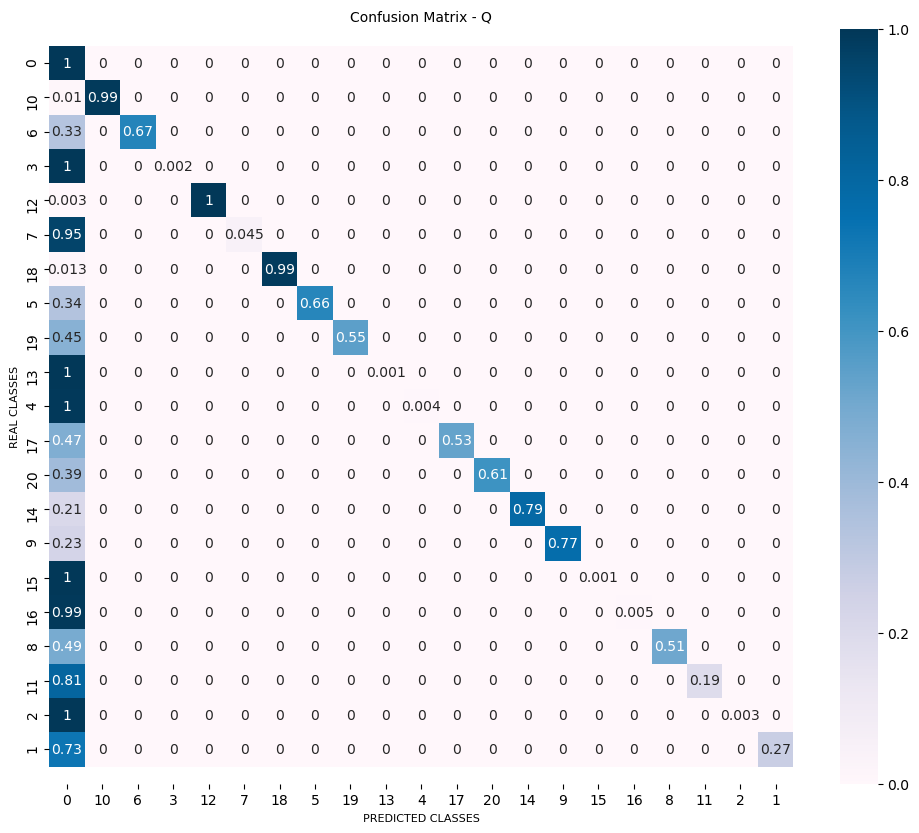

,Precision,Recall,F-score(a=1),F-score(a=0.5),F-score(a=2),Specificity,Accuracy,FPR(FAR),TP,TN,FP,FN,Total
Class,,,,,,,,,,,,,
0,0.624856,1.000000,0.769121,0.714160,0.833248,0.999937,0.999935,0.000063,1,175187,11,0,87063
10,1.000000,0.990430,0.995192,0.996789,0.993599,1.000000,1.000000,0.000000,0,175199,0,0,4911
6,1.000000,0.669917,0.802336,0.858929,0.752740,1.000000,0.999998,0.000000,0,175199,0,0,1333
3,1.000000,0.002328,0.004644,0.006950,0.003487,1.000000,0.999994,0.000000,0,175199,0,0,3437
12,1.000000,0.997238,0.998617,0.999078,0.998157,1.000000,1.000000,0.000000,0,175199,0,0,8328
7,1.000000,0.044834,0.085820,0.123434,0.065776,1.000000,0.999995,0.000000,0,175199,0,0,6446
18,1.000000,0.986523,0.993216,0.995467,0.990975,1.000000,1.000000,0.000000,0,175199,0,0,742
5,1.000000,0.661755,0.796453,0.854425,0.745848,1.000000,0.999998,0.000000,0,175199,0,0,4615
19,1.000000,0.548915,0.708774,0.784976,0.646057,1.000000,0.999997,0.000000,0,175199,0,0,5254


In [18]:
# Desempenho por Q

new_status = y_teste.STATUS.unique()

df_cm = pd.DataFrame(confusion_matrix(pca_results['rotulos_multi'], pca_results['Q_classific_multi']), \
                     index=[i for i in new_status], columns=[i for i in new_status])

# Linha para normalizar os dados
df_cm_norm = round((df_cm.astype('float')/df_cm.sum(axis=1).values.reshape(-1,1)), 3)

# Gráfico da matriz de confusão
plt.figure(figsize=(12,10), dpi=100)
plt.title("Confusion Matrix - Q", fontsize=10)
ax = sn.heatmap(df_cm_norm, annot=True, cmap='PuBu')
ax.set_xlabel("PREDICTED CLASSES", fontsize=8)
ax.set_ylabel("REAL CLASSES", fontsize=8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

cm_values = df_cm_norm.values
    
# Cálculo dos FP, FN e TP para cada classe
tp = np.zeros((len(cm_values),1))
tn = np.zeros((len(cm_values),1))
fp = np.zeros((len(cm_values),1))
fn = np.zeros((len(cm_values),1))
acc = np.zeros((len(cm_values),1))

for i in range(0, len(cm_values)):

    tp[i] = cm_values[i,i]
    fp[i] = cm_values[:,i].sum() - cm_values[i,i]
    fn[i] = cm_values[i,:].sum() - cm_values[i,i]
    tn[i] = len(pca_results['Q_classific_multi']) - tp[i] - fp[i] - fn[i]
    acc[i] = (len(pca_results['Q_classific_multi']) - (cm_values[i,:].sum() + cm_values[:,i].sum() - 2*cm_values[i,i]))/len(pca_results['Q_classific_multi'])

# Cálculo das métricas Precision, Recall e F-Score para cada classe
metricas = precision_recall_fscore_support(pca_results['rotulos_multi'], pca_results['Q_classific_multi'], zero_division=0)

# Arranjo do dataframe e inclusão de outras métricas
metricas_df = pd.DataFrame(list(metricas))
metricas_df = metricas_df.transpose()

metricas_df.columns = ['Precision', 'Recall', 'F-score(a=1)', 'Total']
metricas_df['Accuracy'] = acc
metricas_df['Class'] = new_status
metricas_df['Total'] = metricas_df['Total'].astype(int)

metricas_df['TP'] = tp.astype(int)
metricas_df['TN'] = tn.astype(int)
metricas_df['FP'] = fp.astype(int)
metricas_df['FN'] = fn.astype(int)

metricas_df['Specificity'] = (metricas_df['TN']/(metricas_df['TN'] + metricas_df['FP']))
metricas_df['FPR(FAR)'] = (metricas_df['FP']/(metricas_df['FP'] + metricas_df['TN']))
metricas_df['F-score(a=0.5)'] =\
    (1.5*metricas_df['Precision']*metricas_df['Recall'])/((0.5*metricas_df['Precision']) + metricas_df['Recall'])
metricas_df['F-score(a=2)'] =\
    (3*metricas_df['Precision']*metricas_df['Recall'])/((2*metricas_df['Precision']) + metricas_df['Recall'])
metricas_df['F-score(a=0.5)'].fillna(0, inplace=True)
metricas_df['F-score(a=2)'].fillna(0, inplace=True)

metricas_df = metricas_df.set_index('Class')
metricas_df = metricas_df[['Precision', 'Recall', 'F-score(a=1)', 'F-score(a=0.5)', 'F-score(a=2)', \
                           'Specificity', 'Accuracy', 'FPR(FAR)', 'TP', 'TN', 'FP', 'FN', 'Total']]

metricas_df

In [21]:
pr_micro = precision_score(pca_results['rotulos_multi'], pca_results['Q_classific_multi'], labels=new_status, average='micro')
pr_macro = precision_score(pca_results['rotulos_multi'], pca_results['Q_classific_multi'], labels=new_status, average='macro')
pr_weigh = precision_score(pca_results['rotulos_multi'], pca_results['Q_classific_multi'], labels=new_status, average='weighted')

rc_micro = recall_score(pca_results['rotulos_multi'], pca_results['Q_classific_multi'], labels=new_status, average='micro')
rc_macro = recall_score(pca_results['rotulos_multi'], pca_results['Q_classific_multi'], labels=new_status, average='macro')
rc_weigh = recall_score(pca_results['rotulos_multi'], pca_results['Q_classific_multi'], labels=new_status, average='weighted')

# f1_micro = f1_score(pca_results['rotulos_multi'], pca_results['Q_classific_multi'], labels=new_status, average='micro')
# f1_macro = f1_score(pca_results['rotulos_multi'], pca_results['Q_classific_multi'], labels=new_status, average='macro')
# f1_weigh = f1_score(pca_results['rotulos_multi'], pca_results['Q_classific_multi'], labels=new_status, average='weighted')

print("PRECISION")
print("micro:    {:.2f}%".format((pr_micro*100)))
print("macro:    {:.2f}%".format((pr_macro*100)))
print("weighted: {:.2f}%".format((pr_weigh*100)))

print("\nRECALL")
print("micro:    {:.2f}%".format((rc_micro*100)))
print("macro:    {:.2f}%".format((rc_macro*100)))
print("weighted: {:.2f}%".format((rc_weigh*100)))

# print("\nF-SCORE (a=1)")
# print("micro:    {:.2f}%".format((f1_micro*100)))
# print("macro:    {:.2f}%".format((f1_macro*100)))
# print("weighted: {:.2f}%".format((f1_weigh*100)))
print()

try:
    print("Overall AUC:       {:.2f}%".format((roc_auc_score(pca_results['rotulos_multi'], pca_results['Q_classific_multi'])*100)))
except:
    pass
print("Overall Accuracy:    {:.2f}%".format(accuracy_score(pca_results['rotulos_multi'], pca_results['Q_classific_multi'])*100))

PRECISION
micro:    70.17%
macro:    98.21%
weighted: 81.36%

RECALL
micro:    70.17%
macro:    45.66%
weighted: 70.17%

Overall Accuracy:    70.17%
